In [159]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

from helper_functions import plot_decision_boundary

In [160]:
data = torch.tensor(
    [
        [0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]
    ]
)
labels = torch.tensor([0., 1., 1., 0.])

In [161]:
torch.manual_seed(0)
hidden = 10
model = nn.Sequential(
    nn.Linear(2, hidden),
    nn.ReLU(),
    nn.Linear(hidden, 1)
)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [162]:
epochs = 1000
for epoch in range(epochs):
    y_logits = model(data).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    loss = loss_fn(y_logits, labels)
    acc = accuracy_fn(labels, y_preds)

    if epoch % (epochs//10) == 0:
        print(f"[EPOCH {epoch+1}/{epochs}] Loss: {loss} | Accuracy: {acc}")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()

y_logits = model(data).squeeze()
y_preds = torch.round(torch.sigmoid(y_logits))
acc = accuracy_fn(labels, y_preds)
print(f"[FINAL] Accuracy: {acc}")

[EPOCH 1/1000] Loss: 0.7081388235092163 | Accuracy: 50.0
[EPOCH 101/1000] Loss: 0.5997547507286072 | Accuracy: 75.0
[EPOCH 201/1000] Loss: 0.47714075446128845 | Accuracy: 100.0
[EPOCH 301/1000] Loss: 0.31135350465774536 | Accuracy: 100.0
[EPOCH 401/1000] Loss: 0.17354516685009003 | Accuracy: 100.0
[EPOCH 501/1000] Loss: 0.09954073280096054 | Accuracy: 100.0
[EPOCH 601/1000] Loss: 0.06336046755313873 | Accuracy: 100.0
[EPOCH 701/1000] Loss: 0.04418409243226051 | Accuracy: 100.0
[EPOCH 801/1000] Loss: 0.032780781388282776 | Accuracy: 100.0
[EPOCH 901/1000] Loss: 0.025628898292779922 | Accuracy: 100.0
[FINAL] Accuracy: 100.0


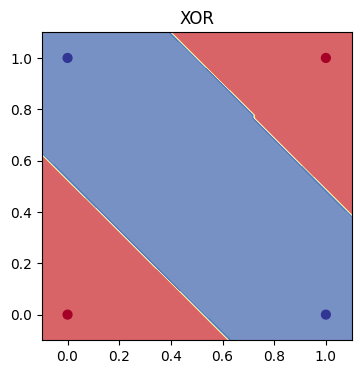

In [163]:
plt.figure(figsize=(4, 4))
plt.title("XOR")
plot_decision_boundary(model, data, labels)

In [164]:
X = data.detach().numpy()
T = labels.detach().numpy()

In [165]:
# Extract weights and biases of trained MLP
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in model.children()]))
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)
L, W[0].shape, W[1].shape

(2, (2, 10), (10, 1))

In [166]:
# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

In [167]:
i = np.random.randint(0, len(data))
prediction = A[L][i]
print(f"Point: {data[i]}, Pred: {1 if prediction>0 else 0} | Label: {labels[i]}")

Point: tensor([0., 0.]), Pred: 0 | Label: 0.0


In [168]:
nb_labels = len(np.unique(labels))
#R = [None] * L + [A[L] * (T[:,None]==np.arange(nb_labels))]
R = [None] * L + [A[L]]

In [169]:
def rho(w, _l):
    return w
def incr(z, _l):
    return z

In [170]:
# All layers except the pixels one
for l in range(1, L)[::-1]:
    w = rho(W[l], l)
    b = rho(B[l], l)

    z = incr(A[l].dot(w)+b, l)
    s = R[l+1] / z
    c = s.dot(w.T)
    R[l] = A[l] * c

In [171]:
w = W[0]
wp = np.maximum(0, w)
wm = np.minimum(0, w)
lb = A[0]*0-1
hb = A[0]*0+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R[0] = A[0]*c - lb*cp - hb*cm

In [172]:
R[0].shape, R[1].shape, R[2].shape

((4, 2), (4, 10), (4, 1))

In [173]:
for i in range(len(data)):
    print(f"P: {data[i].tolist()} | Label: {labels[i]} | Relevance: {R[L][i]}")

P: [0.0, 0.0] | Label: 0.0 | Relevance: [0.]
P: [0.0, 1.0] | Label: 1.0 | Relevance: [3.7827933]
P: [1.0, 0.0] | Label: 1.0 | Relevance: [3.69883]
P: [1.0, 1.0] | Label: 0.0 | Relevance: [0.]


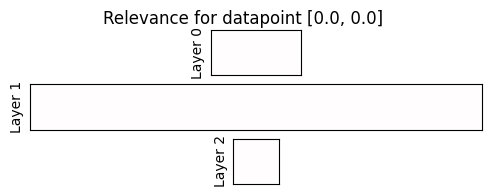

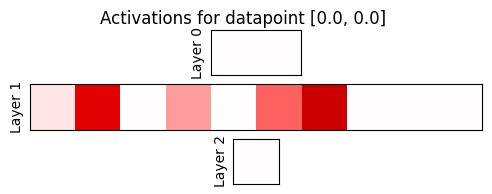

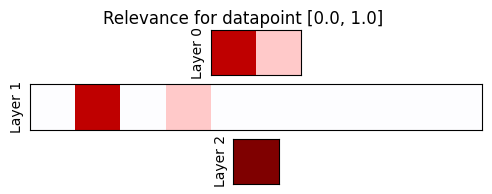

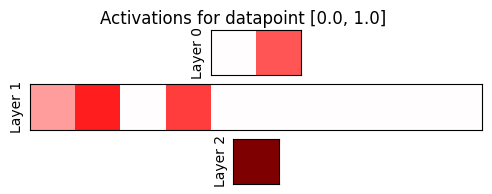

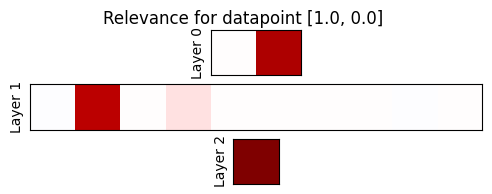

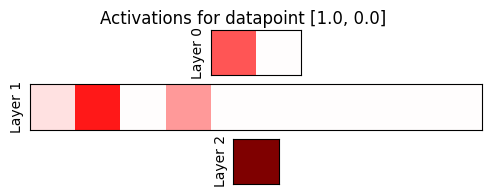

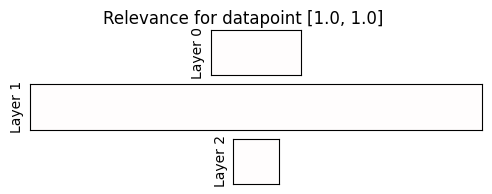

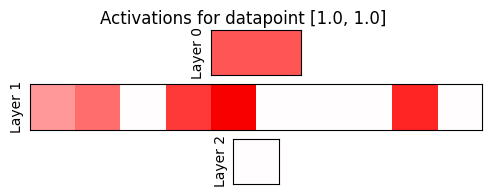

In [174]:
cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
cmap = ListedColormap(cmap)

for i in range(len(data)):
    #print(f"[POINT] {data[i].tolist()}")

    # -- Display relevance --
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        axs[l].imshow(R[l][i].reshape((1, len(R[l][i]))), cmap=cmap, interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        #print(f"    [Layer {l}] {R[l][i]}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    fig.suptitle(f"Relevance for datapoint {data[i].tolist()}")
    plt.show()

    # -- Display activations --
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        axs[l].imshow(A[l][i].reshape((1, len(A[l][i]))), cmap=cmap, interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        #print(f"    [Layer {l}] {R[l][i]}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    fig.suptitle(f"Activations for datapoint {data[i].tolist()}")
    plt.show()